In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
from seaborn import scatterplot, palplot

In [2]:
typesdict = {'cogs 6mo': str, 'quantity 6mos': str}

In [3]:
df = pd.read_excel("data/North Central Sales 6 Months for GIT.xlsx") #, dtype=typesdict)

df['PROD CAT 4 NAME'].fillna("Nonbranded")
df.columns = [name.strip() for name in df.columns];

In [4]:
number_rows = df.shape[0]

Predefine given and derived categories for use. Format: ```str: list(str)```. Derived categories should have strings containing numbers beginning at 1 as their bucket names. 

In [5]:
preset_categories = {
                     'core item flag': ['Y', 'N'],
                     'segment': ['Packaging', 'Facility Solutions'], 
                     'stocking flag': ['Y', 'N'],
                     'national acct flag': ['Y', 'N'],
                     }

In [6]:
derived_categories = {
                      'qty 6mos': [str(x) for x in range(9)],
                      'cogs 6mos': [str(x) for x in range(9)]
                     }

Create "buckets" for derived categories (by formula, by sorted percentile, etc)

In [7]:
bucket_series = []

for attr in derived_categories.keys():
    series = df[attr].astype('float64')
    series.fillna(0)
    
    sorted_copy = series.sort_values()
    
    # TODO - redo -- doesn't work for double-digit number of buckets (was lazy when designing this oops)
    bucket_cutoffs = number_rows // len(derived_categories[attr])
    bucket_assignment = list(''.join([num * bucket_cutoffs for num in derived_categories[attr]]))
    
    while len(sorted_copy.index) != len(bucket_assignment):
        bucket_assignment.append(derived_categories[attr][-1])
    
    df2 = pd.DataFrame(sorted_copy)
    df2['{} subcategory'.format(attr)] = bucket_assignment
    
    df2 = df2.sort_index()

    bucket_series.append(df2['{} subcategory'.format(attr)])

In [8]:
df1 = pd.DataFrame(bucket_series[0])

for item in bucket_series[1:]:
    df1[item.name] = item

df1.head()

,qty 6mos subcategory,cogs 6mos subcategory
0,3,2
1,2,1
2,6,8
3,8,0
4,8,6


Reformat preset categorizies (the Y/N, etc labels) into binary 0s and 1s for use in the model. Will be converted back after clustering for humans :)

In [9]:
# TODO - binarize preset inputs

Add in the preset categories to create the "feature matrix" for clustering:

In [10]:
# for column in preset_categories:
#     df1[column] = df[column]

# df1.head()

Run model and get clusters.

In [11]:
model = KMeans(n_clusters=7)
out = pd.DataFrame(model.fit_predict(df1))

print(out.head())


   0
0  1
1  1
2  0
3  2
4  0


In [12]:
df1['cluster'] = out
df1.head()

,qty 6mos subcategory,cogs 6mos subcategory,cluster
0,3,2,1
1,2,1,1
2,6,8,0
3,8,0,2
4,8,6,0


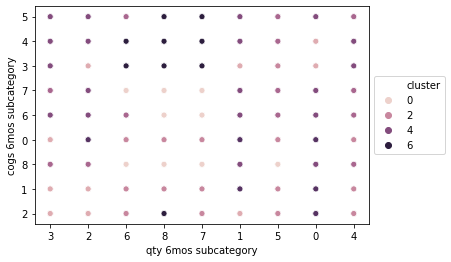

In [13]:
ax = scatterplot(data=df1, x='qty 6mos subcategory', y='cogs 6mos subcategory', hue='cluster')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The above chart shows the different clusters based on the attributes considered (the columns of df1). If a cluster is split up / isn't continously linked to itself, it can imply that we need more clusters. Also, we currently have an even number of items in each bucket -- this makes the chart look like evenly spaced dots that all have the same frequency. If we redefine the "bucketing" of continuous attributes (cogs, revenue, etc.) so that the buckets aren't all even (ie using a distribution such as N(0,1) where the middle buckets have 23% and so on...), the scatterplot will be more random and the clusters more meaningful. 

<a href="https://commons.wikimedia.org/wiki/File:K-means_convergence.gif">This</a> is what the algorithm is trying to do.

Ideally, this algorithm will have a lot of different variables to consider and will be working in 10+ dimensions instead of the two plotted above. These dimensions come from the categories that naturally exist in the data (flags, yes/no fields) and attributes derived from the total population (buckets based on a distribution across the range of cogs/revenue data, etc.).